Train/Test

Note to self:
**Next Steps**
    
* Feature Selection
    * Run SVM with Recursive Feature Elimination (SVM-RFE) to reduce the 82 VOC features to a smaller predictive set
    * Run LASSO logistic regression to identify important VOC features
    * Compare the feature sets selected by both methods

* Model Training and Evaluation
    * Train predictive models (SVM, logistic regression, etc.) using selected features
    * Evaluate model performance using ROC-AUC, sensitivity, and specificity
    * Benchmark results against target triage test accuracy

* Cross-Validation
    * Apply k-fold cross-validation to assess model stability and prevent overfitting

* Results and Interpretation
    * Finalize the list of key VOCs identified by SVM-RFE and LASSO
    * Interpret the biological and chemical relevance of selected VOCs
    * Prepare tables and plots for reporting, including feature importance and ROC curves

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression



In [60]:
# Remove identifiers and non-feature columns. Right now only worrying about VOCs, not demographics yet.
df_main = pd.read_csv("df_main_normalized.csv")

y = df_main["TB Status"]  # Target
X = df_main.drop(columns=["PID", "TB Status", "Age", "BMI", "HIV Status"])  # Features without demographics for now

In [61]:
# QC Checks
print(np.isnan(X).sum().sum())
print(np.isinf(X).sum().sum())
print(X.describe())
print((X.std() == 0).sum())  # Number of zero-variance features

0
0
       000067-64-1_group2  000067-68-5_group1  000074-95-3_group1  \
count        2.520000e+02        2.520000e+02        2.520000e+02   
mean        -1.480766e-11       -2.779198e-12       -3.772503e-12   
std          1.001990e+00        1.001990e+00        1.001990e+00   
min         -2.224944e+00       -2.348779e+00       -2.196138e+00   
25%         -7.734952e-01       -7.300907e-01       -7.045295e-01   
50%         -2.137475e-01       -6.030144e-02        8.827696e-03   
75%          7.690749e-01        6.804719e-01        6.977451e-01   
max          2.517998e+00        2.899073e+00        2.669160e+00   

       000074-97-5_group1  000077-68-9_group1  000078-79-5_group2  \
count        2.520000e+02        2.520000e+02        2.520000e+02   
mean         7.572130e-12        7.314981e-12       -7.758506e-12   
std          1.001990e+00        1.001990e+00        1.001990e+00   
min         -1.275666e+00       -2.304197e+00       -1.125893e+00   
25%         -7.231297e-01    

Above sets up the data and removes the target from the features.

The next cell below is to figure out what number of features is appropriate for SVM-RFE.

In [63]:
# I trust my model and the ROC-AUC is stable so I'm going to supress some warnings for a cleaner output
import warnings
warnings.filterwarnings("ignore", message=".*invalid value encountered in matmul.*")
warnings.filterwarnings("ignore", message=".*divide by zero encountered in matmul.*")
warnings.filterwarnings("ignore", message=".*overflow encountered in matmul.*")

****SVM-RFE SECTION****

5 features → ROC-AUC: 0.813
10 features → ROC-AUC: 0.809
15 features → ROC-AUC: 0.777
20 features → ROC-AUC: 0.761
25 features → ROC-AUC: 0.753
30 features → ROC-AUC: 0.759
35 features → ROC-AUC: 0.743
40 features → ROC-AUC: 0.724


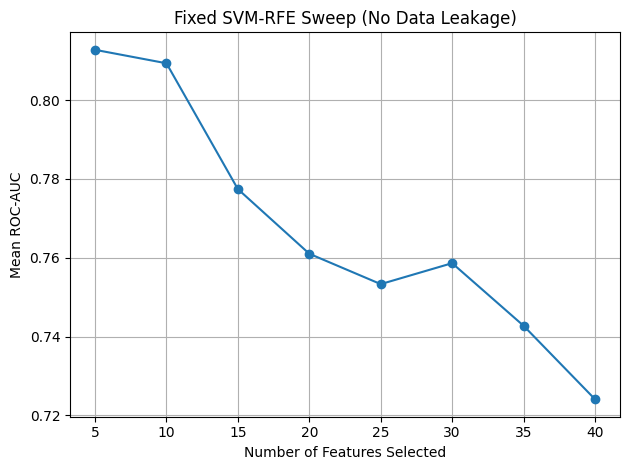

In [70]:
# Config
svc = LinearSVC(C=1, max_iter=10000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_counts = list(range(5, min(41, X.shape[1]), 5))
scores = []

# Sweep
for n in feature_counts:
    pipeline = Pipeline([
        ("feature_selection", RFE(estimator=svc, n_features_to_select=n)),
        ("classifier", svc)
    ])
    score = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc').mean()
    scores.append(score)
    print(f"{n} features → ROC-AUC: {score:.3f}")

# Plot
plt.plot(feature_counts, scores, marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean ROC-AUC")
plt.title("SVM-RFE Sweep")
plt.grid(True)
plt.tight_layout()
plt.show()

**Note to Self** I'm getting a ton of runtime warnings related to divide by zero encoutered. I'm guessing this is due to zero variance in some columns maybe? Everything normalized well so I dont think it's a skew issue. Going to try to run a variance filter.

Tried the variance filter. it didn't drop anything so these errors are something else...



Based off of the ROC-AUC, we are selecting 5 features

In [71]:
svm = svc = LinearSVC(C=1, max_iter=10000)  # going with C=1 for now to avoid overfitting

# select top 5
rfe = RFE(estimator=svm, n_features_to_select=5, step=1)

# Fit RFE model
rfe.fit(X, y)

RFE(estimator=LinearSVC(C=1, max_iter=10000), n_features_to_select=5)

In [72]:
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features.tolist())

# Rankings (1 = selected)
ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()
print("Top 20 ranked features:")
print(ranking.head(20))

Selected features: ['000078-79-5_group2', '000098-86-2_group2', '000149-57-5_group1', '001074-43-7_group1', '001762-27-2_group1']
Top 20 ranked features:
001074-43-7_group1     1
000078-79-5_group2     1
000149-57-5_group1     1
001762-27-2_group1     1
000098-86-2_group2     1
000077-68-9_group1     2
000110-98-5_group1     3
000074-97-5_group1     4
001122-82-3_group1     5
027750-45-4_group1     6
000140-11-4_group1     7
000110-88-3_group1     8
005989-27-5_group1     9
000353-66-2_group1    10
000086-73-7_group1    11
063521-76-6_group3    12
000067-68-5_group1    13
015764-16-6_group1    14
054446-78-5_group1    15
000108-94-1_group1    16
dtype: int64


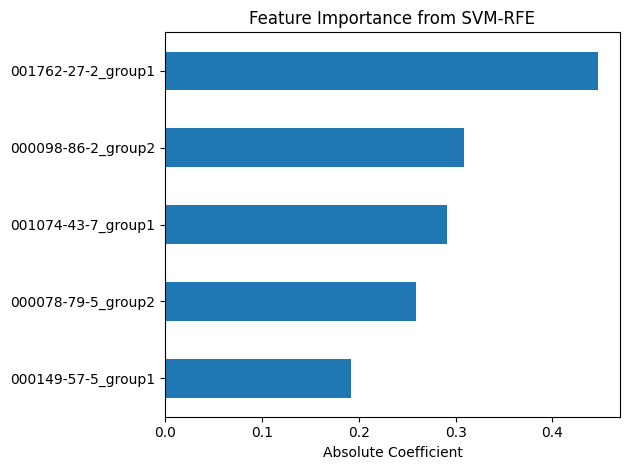

In [73]:
# Visualizing
# Refit SVM just on selected features for coefficient extraction
svm.fit(X[selected_features], y)
coefs = pd.Series(np.abs(svm.coef_[0]), index=selected_features)

# Plot
coefs.sort_values().plot(kind='barh')
plt.title("Feature Importance from SVM-RFE")
plt.xlabel("Absolute Coefficient")
plt.tight_layout()
plt.show()

**Note to self** this makes me wonder if I should cut off the bottom 3 or 4? Make a more simple model? 

In [74]:
# Cross-validate
# Needing this LinearSVC and not just linear. The data is fine but it's breaking. Probably too many features for low number of samples?
# LinearSVC has a better solver for higher dimensions.
pipeline = Pipeline([
    ("feature_selection", RFE(LinearSVC(C=1, max_iter=10000), n_features_to_select=5)),
    ("svm", LinearSVC(C=1, max_iter=10000))
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds seems standard by literature. Random state of 42 similar to above.
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")

print(f"Mean ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Mean ROC-AUC: 0.8127 ± 0.0447


****LASSO****

In [78]:
# Resetting warnings for now
# warnings.resetwarnings()

In [84]:
# LASSO with l1
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.10, max_iter=10000)  # A lower C means fewer features (0.5, 0.1)

# CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('lasso', lasso)
])

scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
print(f"Mean ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

Mean ROC-AUC: 0.8570 ± 0.0334


/Users/tylerstepaniak/Library/Python/3.10/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tylerstepaniak/Library/Python/3.10/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tylerstepaniak/Library/Python/3.10/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tylerstepaniak/Library/Python/3.10/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/tylerstepaniak/Library/Python/3.10/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/tylerstepaniak/Library/Python/3.10/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/tylerstepaniak/Library/

**NOTE** These errors are the same reason as with SVM-RFE, that the dim of the data is very high while the n_sample count isn't super large as well.


LASSO-selected features with odds ratios:
                     Log-Odds Coef  Odds Ratio
000110-98-5_group1        0.145440    1.156549
000470-82-6_group1       -0.001042    0.998958
038165-93-4_group1       -0.003275    0.996731
005989-27-5_group1       -0.020423    0.979784
1000132-10-9_group2      -0.034798    0.965801
000110-43-0_group1       -0.039541    0.961231
054446-78-5_group1       -0.043074    0.957841
063521-76-6_group3       -0.056893    0.944695
003387-41-5_group1       -0.066426    0.935732
000077-68-9_group1       -0.084584    0.918895
000112-31-2_group1       -0.125626    0.881945
000098-86-2_group2       -0.129680    0.878376
001122-82-3_group1       -0.135823    0.872997
000110-88-3_group1       -0.155147    0.856290
000078-79-5_group2       -0.295506    0.744155
000074-97-5_group1       -0.301505    0.739704
001074-43-7_group1       -0.346248    0.707337
001762-27-2_group1       -0.556759    0.573063


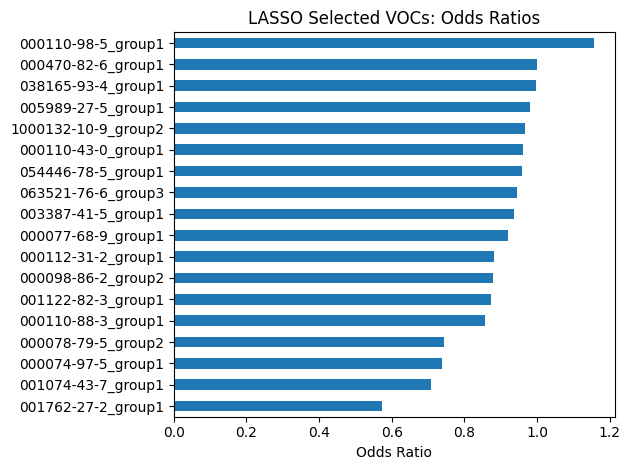

In [85]:
# Fit on full dataset
lasso.fit(X, y)

# coefficients and odds ratios
coefs = pd.Series(lasso.coef_[0], index=X.columns)
nonzero_coefs = coefs[coefs != 0]
odds_ratios = np.exp(nonzero_coefs)

# Combine into a df for report
summary_df = pd.DataFrame({
    "Log-Odds Coef": nonzero_coefs,
    "Odds Ratio": odds_ratios
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO-selected features with odds ratios:")
print(summary_df)

# visualize odds ratios
summary_df["Odds Ratio"].sort_values().plot(kind='barh')
plt.title("LASSO Selected VOCs: Odds Ratios")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

So, LASSO chose 18 features and all but one are negative predictors with one being a positive predictor.

Was there overlap with LASSO's selection and SVM-RFE?
YES!
* SVM-RFE's 5 chosen were:
    * 001762-27-2_group1
    * 000098-86-2_group2
    * 001074-43-7_group1
    * 000078-79-5_group2
    * 000149-57-5_group1
* LASSO's that matched were:
    * 001762-27-2_group1       -0.556759    0.573063
    * 000098-86-2_group2       -0.129680    0.878376
    * 001074-43-7_group1       -0.346248    0.707337
    * 000078-79-5_group2       -0.295506    0.744155
    * but did not include the 5th that SVM-RFE chose

This similiarity makes sense, as these are, ideally, impactful predictors.

****LASSO Based On SVM-RFE Features****

Mean ROC-AUC (LASSO on SVM-RFE): 0.8565 ± 0.0200

LASSO-on-RFE selected features with odds ratios:
                    Log-Odds Coef  Odds Ratio
000078-79-5_group2      -0.282566    0.753847
000098-86-2_group2      -0.378170    0.685114
001074-43-7_group1      -0.417778    0.658508
001762-27-2_group1      -0.809627    0.445024


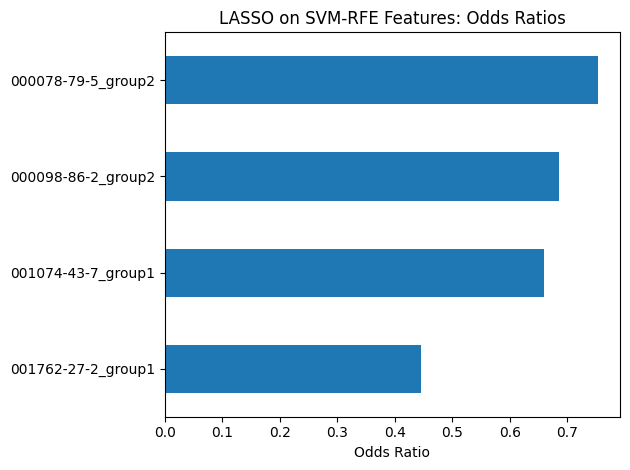

In [88]:
# SVM-RFE selected features:

selected_features = [
    '001762-27-2_group1',
    '000098-86-2_group2',
    '001074-43-7_group1',
    '000078-79-5_group2',
    '000149-57-5_group1']

X_sub = df_main[selected_features]
y = df_main["TB Status"]  # this hasn't changed

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, max_iter=10000)  # same penalty as previous LASSO

# CV performance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lasso, X_sub, y, cv=cv, scoring="roc_auc")
print(f"Mean ROC-AUC (LASSO on SVM-RFE): {scores.mean():.4f} ± {scores.std():.4f}")

# Fit final model
lasso.fit(X_sub, y)

# coefficients and odds ratios
coefs = pd.Series(lasso.coef_[0], index=X_sub.columns)
nonzero_coefs = coefs[coefs != 0]
odds_ratios = np.exp(nonzero_coefs)

# report
summary_df = pd.DataFrame({
    "Log-Odds Coef": nonzero_coefs,
    "Odds Ratio": odds_ratios
}).sort_values("Odds Ratio", ascending=False)

print("\nLASSO-on-RFE selected features with odds ratios:")
print(summary_df)

# Visualize
summary_df["Odds Ratio"].sort_values().plot(kind='barh')
plt.title("LASSO on SVM-RFE Features: Odds Ratios")
plt.xlabel("Odds Ratio")
plt.tight_layout()
plt.show()

So, 000149-57-5_group1 was dropped as it was not found important by LASSO

**TODO** 

* Plot ROC Curves for each model
* 